#Final Model
- Consists of 2 parts: Unsupervised Learning part and Supervised Learning part

Unsupervised Learning part
- Autoencoder embeddings
- clustering

Supervised Learning part
- feature selection
- running ML model

### Supervised Learning Part

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

LOADING DATA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Analytics Project/EDA/song_data_transformed.csv')
df.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,decade
0,2.585174,0.868312,0.336235,1.590276,0.429502,-1.227755,-0.422918,-0.776569,-0.277259,-0.491799,0.139766,-0.058157,0.573111,0.200898,0.781929
1,2.431351,-2.421427,-0.078151,0.750118,0.224346,0.814495,-0.494386,-0.847012,-0.277260,-0.232784,-1.440773,-1.305936,0.413941,0.200898,0.781929
2,2.277527,-0.799358,0.376662,-1.210251,0.302673,0.814495,-0.322864,-0.986680,-0.276703,-0.629724,-0.841832,1.753530,-0.214086,0.200898,0.781929
3,2.200616,0.282022,-0.345986,0.470065,0.003022,0.814495,2.054246,-0.471933,-0.277236,-0.323439,-0.209616,2.286157,0.213738,0.200898,0.097001
4,1.969881,-0.323811,-0.659303,-1.210251,-0.038232,-1.227755,-0.304173,-0.582575,-0.277274,-0.342865,-0.118111,0.426683,0.632939,0.200898,0.097001


In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/Analytics Project/EDA/song_data_cleaned.csv')
df2.head()

,track_id,track_name,artist_name,popularity,album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,decade
0,1Es7AUAhQvapIcoh3qMKDL,Timeless (with Playboi Carti),"['The Weeknd', 'Playboi Carti']",92,Timeless,0.769,0.722,11,-5.485,0,0.0507,0.05840,0.000003,0.1110,0.570,119.973,audio_features,256000,4,2020
1,7CyPwkp0oE8Ro9Dd5CUDjW,"One Of The Girls (with JENNIE, Lily Rose Depp)","['The Weeknd', 'JENNIE', 'Lily-Rose Depp']",90,The Idol Episode 4 (Music from the HBO Origina...,0.264,0.640,8,-6.221,1,0.0442,0.03930,0.000002,0.1510,0.190,84.828,audio_features,244685,4,2020
2,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,['The Weeknd'],88,After Hours,0.513,0.730,1,-5.940,1,0.0598,0.00143,0.000095,0.0897,0.334,171.001,audio_features,200040,4,2020
3,7MXVkk9YMctZqd1Srtv4MB,Starboy,"['The Weeknd', 'Daft Punk']",87,Starboy,0.679,0.587,7,-7.015,1,0.2760,0.14100,0.000006,0.1370,0.486,186.003,audio_features,230453,4,2010
4,2LBqCSwhJGcFQeTHMVGwy3,Die For You,['The Weeknd'],84,Starboy,0.586,0.525,1,-7.163,0,0.0615,0.11100,0.000000,0.1340,0.508,133.629,audio_features,260253,4,2010


AUTOENCODER

- training a "denoising" autoencoder to ensure model will train well

In [ ]:
def zero_out(df, num_features_to_zero=2):
    df_zeroed = df.copy()
    num_rows, num_cols = df_zeroed.shape

    for row_idx in range(num_rows):
        # Randomly choose `num_features_to_zero` columns without replacement
        random_columns = np.random.choice(num_cols, size=num_features_to_zero, replace=False)
        # Set the selected columns to 0 for the current row
        df_zeroed.iloc[row_idx, random_columns] = 0

    return df_zeroed



In [ ]:
# training/validation data
df_np = df.to_numpy()

df_zeroed = zero_out(df)
df_zeroed_np = df_zeroed.to_numpy()

indices = np.random.permutation(df.shape[0])

train_end = int(0.7 * len(df_np))

train_indices = indices[:train_end]
valid_indices = indices[train_end:]

data_train_TRUE = df_np[train_indices]
data_valid_TRUE = df_np[valid_indices]

data_train_zerod = df_zeroed_np[train_indices]
data_valid_zerod = df_zeroed_np[valid_indices]

In [ ]:
# building a simple model
import torch
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(15, 2048),
            nn.ReLU(),
            nn.Linear(2048,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.Dropout(0.05),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16,128),
            nn.ReLU(),
            nn.Linear(128,512),
            nn.Dropout(0.05),
            nn.ReLU(),
            nn.Linear(512,1024),
            nn.ReLU(),
            nn.Linear(1024,2048),
            nn.ReLU(),
            nn.Linear(2048, 15) # outputs are norm. distb'd. between [-inf,inf] with mean 0
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def train(model, train_true, valid_true, train_zerod, valid_zerod, batch_size=64, num_epochs=5, learning_rate=0.005):
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    import matplotlib.pyplot as plt
    from torch.optim.lr_scheduler import StepLR as StepLR

    np.random.seed(42)

    # using GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create DataLoaders for mini-batching

    train_zerod_tensor = torch.from_numpy(train_zerod).float().to(device)
    train_true_tensor = torch.from_numpy(train_true).float().to(device)
    valid_zerod_tensor = torch.from_numpy(valid_zerod).float().to(device)
    valid_true_tensor = torch.from_numpy(valid_true).float().to(device)

    train_dataset = TensorDataset(train_zerod_tensor, train_true_tensor)
    valid_dataset = TensorDataset(valid_zerod_tensor, valid_true_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    criterion = nn.MSELoss()  # Mean Squared Error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-4)
    scheduler = StepLR(optimizer, step_size= 30, gamma=0.5)

    epochs, train_loss, val_loss = [], [], []

    for epoch in range(num_epochs):
        # Training loop with mini-batching
        for data,target in train_loader:
            data,target = data.to(device),target.to(device)
            recon = model(data)
            loss = criterion(recon, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        scheduler.step()

        # Average training loss
        total_train_loss = 0
        with torch.no_grad():
          for data, target in train_loader:
            data,target = data.to(device),target.to(device)
            recon = model(data)
            loss = criterion(recon, target)
            total_train_loss += loss.item()
        train_loss.append(total_train_loss / len(train_loader))

        # Validation loop
        total_val_loss = 0
        with torch.no_grad():
            for data,target in valid_loader:
                data,target = data.to(device),target.to(device)
                recon = model(data)
                loss = criterion(recon, target)
                total_val_loss += loss.item()
        val_loss.append(total_val_loss / len(valid_loader))

        # Logging
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}")

        # Save model every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), f"/content/drive/MyDrive/Analytics Project/Final Model/model_epoch_{epoch + 1}.pt")

        epochs.append(epoch + 1)

    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


Using device: cuda
Epoch [1/70], Train Loss: 0.2934, Validation Loss: 0.2998
Epoch [2/70], Train Loss: 0.2088, Validation Loss: 0.2175
Epoch [3/70], Train Loss: 0.2153, Validation Loss: 0.2191
Epoch [4/70], Train Loss: 0.1635, Validation Loss: 0.1738
Epoch [5/70], Train Loss: 0.1641, Validation Loss: 0.1747
Epoch [6/70], Train Loss: 0.1525, Validation Loss: 0.1651
Epoch [7/70], Train Loss: 0.1470, Validation Loss: 0.1592
Epoch [8/70], Train Loss: 0.1548, Validation Loss: 0.1654
Epoch [9/70], Train Loss: 0.2007, Validation Loss: 0.2054
Epoch [10/70], Train Loss: 0.1750, Validation Loss: 0.1836
Epoch [11/70], Train Loss: 0.1382, Validation Loss: 0.1530
Epoch [12/70], Train Loss: 0.1413, Validation Loss: 0.1553
Epoch [13/70], Train Loss: 0.1344, Validation Loss: 0.1513
Epoch [14/70], Train Loss: 0.1328, Validation Loss: 0.1510
Epoch [15/70], Train Loss: 0.1309, Validation Loss: 0.1492
Epoch [16/70], Train Loss: 0.1534, Validation Loss: 0.1684
Epoch [17/70], Train Loss: 0.1420, Validation 

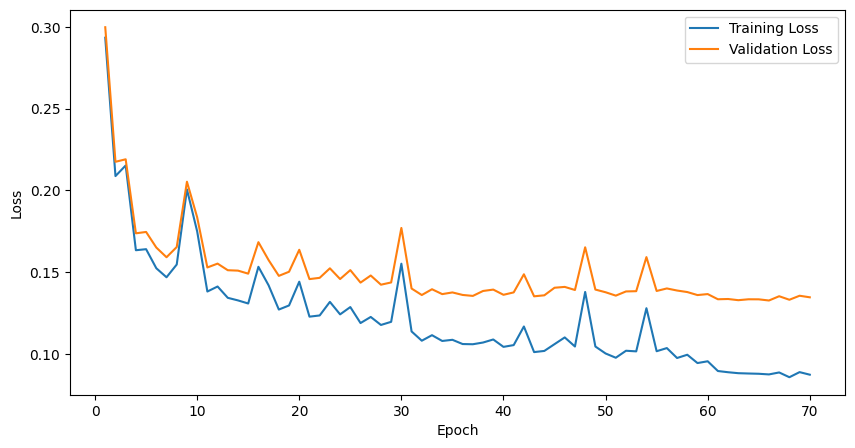

In [ ]:
model = AutoEncoder()
train(model, data_train_TRUE, data_valid_TRUE, data_train_zerod, data_valid_zerod, batch_size=64, num_epochs=70, learning_rate=0.0003)

In [ ]:
# getting best model
Bestmodel = AutoEncoder()
Bestmodel.load_state_dict(torch.load('/content/drive/MyDrive/Analytics Project/Final Model/model_epoch_70.pt', weights_only=True))



<All keys matched successfully>

In [ ]:
# getting song embeddings for each song

  # gettting encoder
encoder = Bestmodel.encoder

  # getting tensors for df
df_np = df.to_numpy()
data_tensor = torch.tensor(df_np, dtype=torch.float32)

# Get embeddings
with torch.no_grad():
    encoder.eval()
    embeddings = encoder(data_tensor)

# getting an embedding dataframe
embeddings_np = embeddings.numpy()
embeddings_df = pd.DataFrame(embeddings_np)

# Display embeddings
embeddings_df # each column is 1 song embedding


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.093700,0.962674,0.900975,-0.656936,0.128117,1.269141,0.066678,0.022140,-0.905994,-0.499558,1.357825,0.169495,0.343522,0.014479,0.154397,-0.844121
1,-0.403595,0.369391,1.413805,-0.407378,-0.054568,-0.096612,0.612128,0.852102,-1.959170,-0.503147,0.253897,0.210157,1.509180,-1.750226,-0.401036,-1.201358
2,0.098297,-0.186173,0.596966,0.851851,0.551716,0.640690,0.815549,0.735135,-1.722415,-0.884948,0.263132,-0.099958,1.359606,0.310165,-0.710294,-1.096912
3,0.190548,1.095511,0.451729,-0.147612,0.370788,0.890330,0.942434,1.483094,-1.612494,-1.097371,0.732502,-0.632432,0.549447,0.928333,-0.705553,-1.648430
4,-0.460402,-0.072106,-0.014140,0.171830,0.227975,0.241020,-0.296745,-0.159980,-1.546235,-0.256118,1.091501,-0.494071,0.748326,0.549010,-0.713511,-0.300329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22075,0.056099,0.764049,-0.328745,1.056428,-0.442991,0.534541,-0.055919,1.278854,0.919024,-0.881595,-1.243013,0.431392,-0.201999,-0.061261,-0.053534,0.281631
22076,0.492321,0.292045,0.417006,1.235001,-0.228188,-1.007024,0.487750,0.950554,0.907062,-1.034670,-2.067561,0.884876,1.224418,-1.181937,-0.980174,0.467655
22077,-0.088535,0.517322,-1.002692,1.289982,-0.897344,-0.851390,-1.233263,0.389223,0.500468,-0.090992,-1.339617,-0.241615,0.023325,-0.331135,-1.190542,1.472257
22078,0.570410,0.666586,-0.164892,0.806028,0.774505,0.404352,-0.226857,0.022599,1.730397,0.267324,-0.548520,0.650039,-0.038702,-0.174974,-0.927020,0.440438


### Clustering each song

--> used k-means clustering since density-based clustering wasn't working very well

--> used elbow plot for hyper-parameter tuning

In [ ]:
# standardizing song embeddings
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_embeddings = scaler1.fit_transform(embeddings_np)

# clustering using kmeans - (dbscan isnt working well)
from sklearn.cluster import KMeans

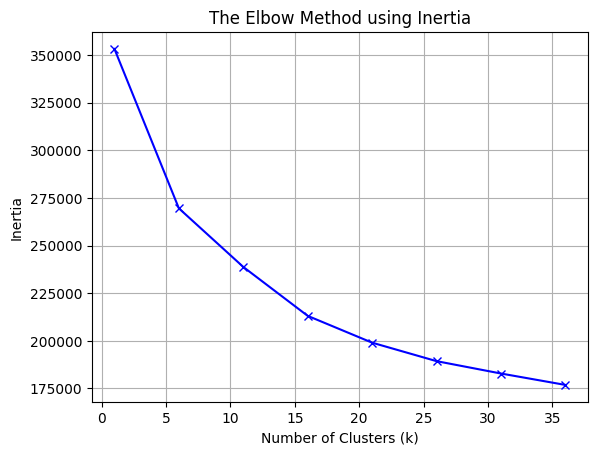

In [ ]:
#hyperparamter tuning for optimal k (using interia)
inertias = []
K = []
for k in range (1,40,5):
  K.append(k)
  kmeans_model = KMeans(n_clusters = k)
  inertias.append(kmeans_model.fit(scaled_embeddings).inertia_)

# Plotting elbow plot
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.grid()
plt.show()

The elbow point seems to occur near k = 5, so this k value will be chosen

In [ ]:
# performing clustering
kmeans_model = KMeans(n_clusters = 5)
kmeans_model.fit_transform(scaled_embeddings)
cluster_labels = kmeans_model.labels_

# Add cluster labels to embedding dataframe
embeddings_df['Cluster'] = cluster_labels

# Count the number of points in each cluster
cluster_counts = embeddings_df['Cluster'].value_counts()
print("Cluster Counts:\n", cluster_counts)


Cluster Counts:
 Cluster
2    8403
0    4801
4    3409
3    3250
1    2217
Name: count, dtype: int64


In [ ]:
#Visualizing the Clusters with t-SNE
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=30, random_state=42)
embeddings_3d = tsne.fit_transform(scaled_embeddings)

KeyboardInterrupt: 

In [ ]:
projection = pd.DataFrame(columns=['x', 'y','z'], data=embeddings_3d)
projection['cluster'] = embeddings_df['Cluster']
projection['track_name'] = df2['track_name']
projection['artist_name'] = df2['artist_name']

# Step 4: Create a 3D plot
fig = plt.figure(figsize=(12, 8))

fig = px.scatter_3d(
    projection, x='x', y='y',z='z', color='cluster', hover_data=['x', 'y','z', 'track_name', 'artist_name'])
fig.show()

<Figure size 1200x800 with 0 Axes>

### Getting potential song recommendations from NN to playlist


In [ ]:
playlist = pd.read_csv('/content/drive/MyDrive/Analytics Project/Initial Model/playlist_df _TRIAL.csv')
playlist['release_date'] = playlist['release_date'].astype('datetime64[ns]')
playlist['release_date'] = playlist['release_date'].dt.year

In [ ]:
playlist_numeric = playlist.select_dtypes(include=np.number)
playlist_numeric['decade'] = (playlist_numeric['release_date'] // 10) * 10
playlist_numeric = playlist_numeric.dropna()
playlist_numeric.drop(columns=['release_date'], inplace=True)
playlist_numeric.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,decade
0,0,0.497,0.849,9,-5.352,1,0.0612,0.00985,0.000000,0.106,0.720,169.937,261532,4,1980
1,84,0.574,0.913,6,-4.793,0,0.1330,0.06100,0.001580,0.156,0.423,115.728,208400,4,1970
2,83,0.532,0.887,0,-3.757,1,0.0335,0.07780,0.000206,0.294,0.794,122.509,249293,4,1980
3,85,0.505,0.754,4,-7.435,1,0.0366,0.13200,0.000000,0.204,0.510,119.204,249600,4,1980
4,69,0.391,0.402,0,-9.961,0,0.0539,0.28900,0.000000,0.243,0.228,143.879,354320,4,1970


In [ ]:
# Calculate the mean of each numeric column
playlist_mean = playlist_numeric.mean()

# Calculate the mode for categorical/ordinal columns
most_common_key = playlist_numeric['key'].mode()[0]
most_common_mode = playlist_numeric['mode'].mode()[0]
most_common_time_signature = playlist_numeric['time_signature'].mode()[0]

# Create a DataFrame to display both mean and most common values
playlist_summary = playlist_mean.to_frame(name='mean_value').T
playlist_summary['key'] = most_common_key
playlist_summary['mode'] = most_common_mode
playlist_summary['time_signature'] = most_common_time_signature

playlist_summary

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,decade
mean_value,66.531073,0.516922,0.736696,9,-7.757869,1,0.058049,0.131311,0.032966,0.187681,0.553875,126.205465,256540.579096,4,1982.570621


In [ ]:
# import scaler used to scale 25,000 song data
import joblib
scaler5 = joblib.load('/content/drive/MyDrive/Analytics Project/Final Model/scaler.pkl')

# song_data = pd.read_csv('/content/drive/MyDrive/Analytics Project/EDA/song_data_cleaned.csv')
# song_data= song_data.select_dtypes(include=np.number)
# song_data = song_data.dropna()
# song_data_sub = song_data

# scaler5 = StandardScaler()
# scaler5.fit(song_data_sub.to_numpy())


In [ ]:
playlist_summary_scaled = scaler5.transform(playlist_summary)
playlist_summary_scaled

array([[ 0.62631785, -0.77380653,  0.41050228,  1.03017046, -0.20404855,
         0.81449502, -0.34211481, -0.50766616, -0.07971814,  0.00473565,
         0.07269726,  0.16311943,  0.58071559,  0.20089808, -1.78171563]])

In [ ]:
# encoding playlist summary
playlist_tensor = torch.from_numpy(playlist_summary_scaled).float()
with torch.no_grad():
  encoder.eval()
  mean_playlist_embedding = encoder(playlist_tensor)
mean_playlist_embedding = scaler1.transform(mean_playlist_embedding.numpy())

In [ ]:
# getting cluster, mean playlist embedding belongs to
predicted_cluster = kmeans_model.predict(mean_playlist_embedding)
predicted_label = predicted_cluster[0]
print(predicted_label)

3


In [ ]:
# getting 10 nearest songs to mean playlist embedding to provide as potential song recommendations
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

cluster_embeddings = embeddings_df[embeddings_df['Cluster'] == predicted_label]
embeddings_from_cluster = cluster_embeddings.drop(columns=['Cluster'])

#song_distances = pairwise_distances(embeddings_from_cluster.to_numpy(), mean_playlist_embedding, metric='euclidean').flatten()
song_distances = cosine_similarity(embeddings_from_cluster.to_numpy(), mean_playlist_embedding).flatten() # cosine similarity seems to be working pretty well

In [ ]:
song_data = df2

In [ ]:
# getting song information from cluster
cluster_song_data = song_data.loc[cluster_embeddings.index]
cluster_song_data['distance'] = song_distances

# Filter out songs already in the playlist from cluster
playlist_song_ids = playlist['track_id'].tolist()
cluster_song_data = cluster_song_data[~cluster_song_data['track_id'].isin(playlist_song_ids)]

# Sort by distance to find the 20 closest songs in cluster to mean song embedding
closest_songs = cluster_song_data.nlargest(20, 'distance')

# Display the closest songs
closest_songs

,track_id,track_name,artist_name,popularity,album,danceability,energy,key,loudness,mode,...,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,decade,distance
6019,1H4idkmruFoJBg1DvUv2tY,Band On The Run - 2010 Remaster,"['Paul McCartney', 'Wings']",68,Band On The Run (Standard),0.479,0.601,7,-8.806,1,...,0.082300,0.001410,0.1110,0.669,124.966,audio_features,313027,4,1970,0.813802
12684,5vYA1mW9g2Coh1HUFUSmlb,3AM,['Matchbox Twenty'],71,Yourself or Someone Like You,0.521,0.673,8,-8.685,1,...,0.005730,0.000000,0.1200,0.543,108.031,audio_features,225947,4,1990,0.769828
6953,0ePI3CMwhjRV3ZWas3gTU9,Entre Caníbales - Remasterizado 2007,['Soda Stereo'],62,Canción Animal (Remastered),0.551,0.608,7,-10.231,1,...,0.005590,0.014300,0.1370,0.604,112.318,audio_features,246693,4,1990,0.767134
3139,1H5IfYyIIAlgDX8zguUzns,Suspicious Minds,['Elvis Presley'],74,From Elvis in Memphis,0.487,0.382,7,-10.889,1,...,0.042200,0.000005,0.4110,0.714,116.557,audio_features,261280,4,1960,0.754291
3123,7sNhXWrg9eW3qRqeuePaIC,Orange Crush - Remastered 2013,['R.E.M.'],58,Green (Remastered),0.568,0.701,9,-10.453,1,...,0.000613,0.002580,0.1700,0.638,120.678,audio_features,231640,4,1980,0.753891
19499,7gh2v4IHnxdiwSgA6xluhe,Through the Fire,['Chaka Khan'],62,I Feel for You,0.563,0.593,8,-7.099,1,...,0.192000,0.000018,0.1450,0.428,130.744,audio_features,288653,4,1980,0.742097
1271,2N2yrmodOnVF10mKvItC9P,Don't Cry (Original),"[""Guns N' Roses""]",75,Use Your Illusion I,0.455,0.589,11,-8.640,1,...,0.001840,0.003580,0.1040,0.254,124.634,audio_features,283733,4,1990,0.736699
3764,7HrzErXq3TsKOY1gmdIShB,The River,['Bruce Springsteen'],62,The River,0.587,0.536,7,-11.248,1,...,0.179000,0.000028,0.3050,0.590,117.498,audio_features,301547,4,1980,0.733558
2563,5lQKRR3MdJLtAwNBiT8Cq0,Lyin' Eyes - 2013 Remaster,['Eagles'],68,One of These Nights (2013 Remaster),0.669,0.673,7,-9.754,1,...,0.203000,0.027100,0.1640,0.867,132.680,audio_features,381999,4,1970,0.725514
8817,43eBgYRTmu5BJnCJDBU5Hb,Rio - 2009 Remaster,['Duran Duran'],60,Rio (Collector's Edition),0.544,0.873,9,-7.425,1,...,0.041500,0.000018,0.0925,0.676,140.902,audio_features,337333,4,1980,0.723313
